IDEAS
- what if I set all values == low quantilne equal to 0?
    - how to deal with high values then?
 
- vypnut / spravit sam ten gauss. rozm. v meijre.
- okrajove podmienky ? v ose z?

- segmentovat tunilky v tom upravenou obrazku

- vyskusat na RORPo perc. stretch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
%matplotlib inline

In [2]:
def percentile_stretch(arr, l = 0.05, h=0.95):
    arr = arr.astype(np.float64).copy()
    ql, qh = np.quantile(arr, l), np.quantile(arr, h)
    arr[arr < ql] = ql
    arr[arr > qh] = qh
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    return arr

# Import data

In [3]:
raw_data = skimage.io.imread('180322_Sqh-mCh Tub-GFP 16h_110_time-10.tif.files.tif')

In [4]:
raw_data.shape

(7, 512, 512)

In [5]:
print(f"min={raw_data.min()}; max={raw_data.max()}")

min=218; max=4095


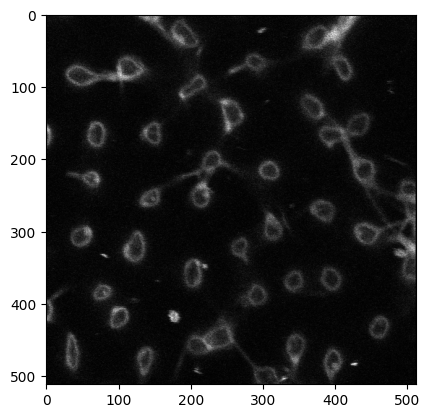

In [6]:
plt.imshow(raw_data[0], 'gray')

In [7]:
# Raw normalised to [0,1]
norm_data = percentile_stretch(raw_data, 0, 1)

# Vesselness Meijering filter

## Try the filter without preprocessing

In [8]:
result = skimage.filters.meijering(raw_data, black_ridges=False)

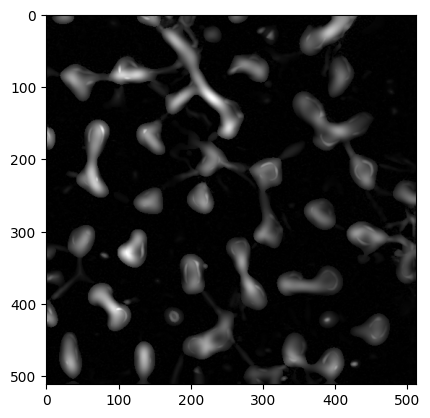

In [9]:
plt.imshow(result[0], 'gray')

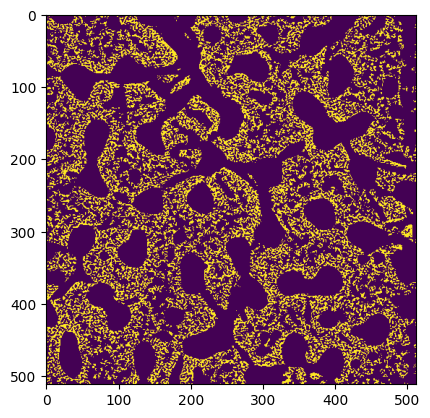

In [10]:
plt.imshow(result[0] == result[1])

## Try the vesselness fitler with linear stretch to [0,255]

(array([1.548442e+06, 1.869320e+05, 7.168400e+04, 1.976800e+04,
        5.748000e+03, 1.695000e+03, 4.840000e+02, 1.500000e+02,
        5.400000e+01, 5.100000e+01]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

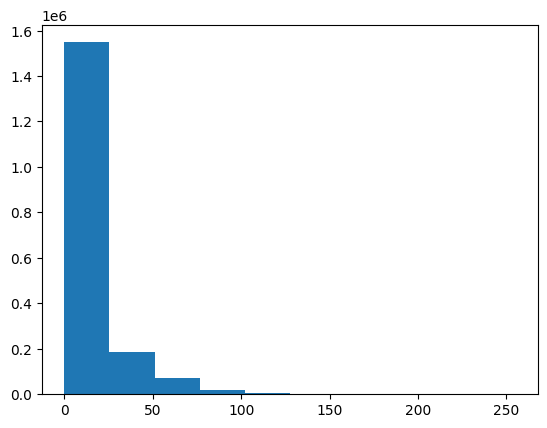

In [11]:
lin_data = (raw_data - raw_data.min()) / (raw_data.max() - raw_data.min())
lin_data *= 255
plt.hist(lin_data.flatten())

In [143]:
result = skimage.filters.meijering(lin_data, black_ridges=False)

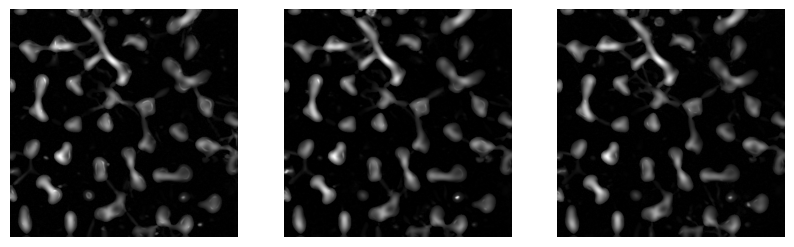

In [144]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 8))
ax[0].imshow(result[0], 'gray')
ax[1].imshow(result[3], 'gray')
ax[2].imshow(result[6], 'gray')
for a in ax:
    a.axis('off')

## Try the vesselness filter with percentile stretch (5%-95%)

(array([970323., 407387., 135314.,  75780.,  58929.,  47342.,  37214.,
         28773.,  21874.,  52072.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

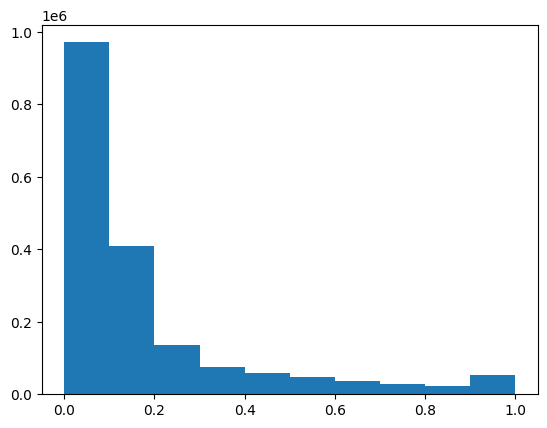

In [157]:
percentile_data = percentile_stretch(raw_data, l=0.02, h=0.98)

# Histogram
plt.hist(percentile_data.flatten())

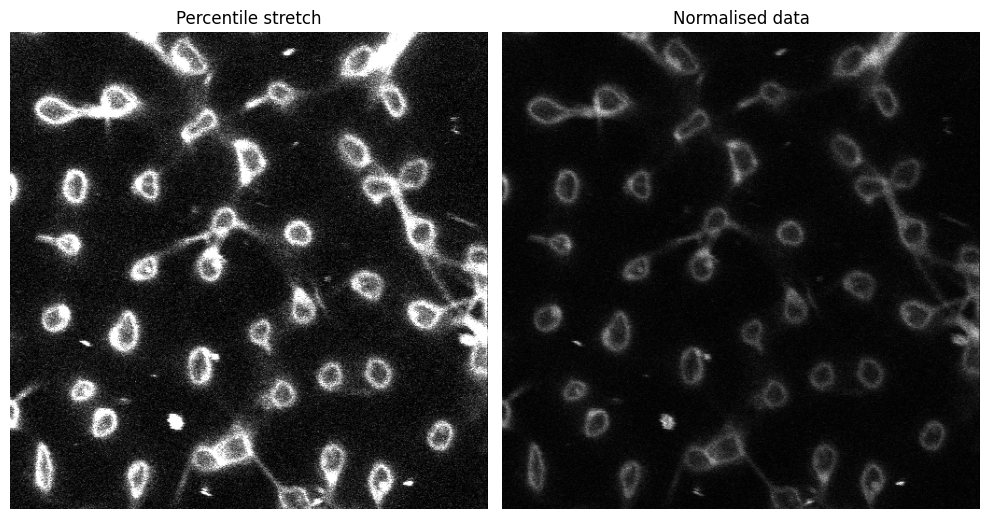

In [158]:
#plt.imshow(percentile_data[0], 'gray')
fig, ax = plt.subplots(ncols=2, figsize=(10, 8))
ax[0].imshow(percentile_data[0], 'gray')
ax[0].set_title("Percentile stretch")
ax[1].imshow(norm_data[0], 'gray')
ax[1].set_title("Normalised data")
for a in ax:
    a.axis('off')
fig.tight_layout()

In [159]:
# Now run the vesselness filter
result = skimage.filters.meijering(percentile_data, black_ridges=False)

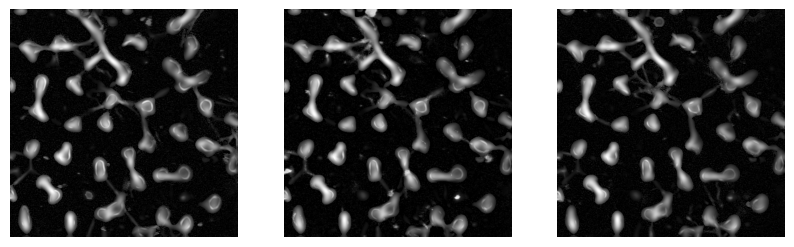

In [160]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 8))
ax[0].imshow(result[0], 'gray')
ax[1].imshow(result[3], 'gray')
ax[2].imshow(result[6], 'gray')
ax[2].imshow(result[6], 'gray')
for a in ax:
    a.axis('off')

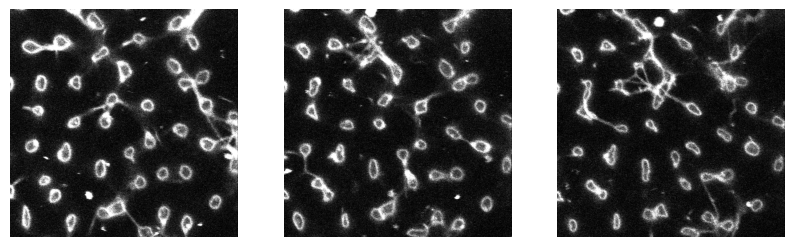

In [161]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 8))
ax[0].imshow(percentile_data[0], 'gray')
ax[1].imshow(percentile_data[3], 'gray')
ax[2].imshow(percentile_data[6], 'gray')
for a in ax:
    a.axis('off')

# Extracting the main pillars

## Binarise

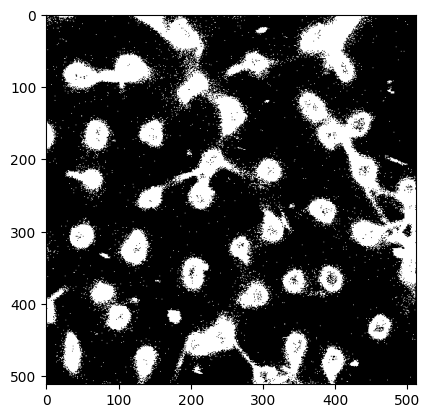

In [39]:
thresh_otsu = skimage.filters.threshold_otsu(percentile_data)
bin_data = percentile_data > thresh_otsu
plt.imshow(bin_data[0], 'gray')

## Morphological operators

In [150]:
def fillhole_morphology(arr):
    if type(arr) == list:
        arr = np.array(arr)
    
    # Create the marker image
    t_max = arr.max()
    marker = arr.copy()

    if len(marker.shape) == 1:
        marker[1:-2] = t_max
    if len(marker.shape) == 3:
        marker[:, 1:-2, 1:-2] = t_max

    # Run reconstruction
    res = skimage.morphology.reconstruction(seed=marker, mask=arr, method='erosion')
    return res, marker

def create_umbra(arr):
    if type(arr) == list:
        arr = np.array(arr)
    
    assert len(arr.shape) == 1

    lvls = arr.max()
    umbra = np.zeros(shape=(lvls+1, arr.shape[0]))
    #umbra[-1, :] = 1
    # for t in range(lvls):
    #     umbra[lvls-t, :] = arr <= t
    # return umbra[::-1, :]

    for t in range(lvls+1):
        umbra[t, :] = arr >= t
    return umbra[:, :]

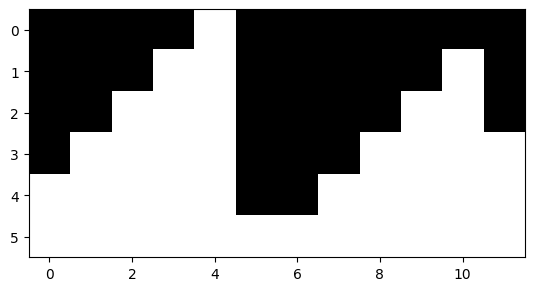

In [151]:
arr = [1,2,3,4,5,0,0,1,2,3,4,2]
umbra = create_umbra(arr)
plt.imshow(umbra[::-1,:], 'gray')

In [152]:
#plt.imshow(fillhole_morphology(arr), 'gray')

filled, marker = fillhole_morphology(arr)
marker
# plt.imshow(create_umbra(fillhole_morphology(arr)[0]), 'gray')

array([1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2])

In [154]:
filled = filled.astype(int)
filled

array([1, 2, 3, 4, 5, 4, 4, 4, 4, 4, 4, 2])

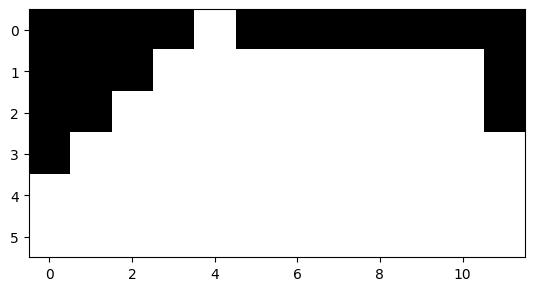

In [155]:
plt.imshow(create_umbra(filled)[::-1], 'gray')

## Fillhole

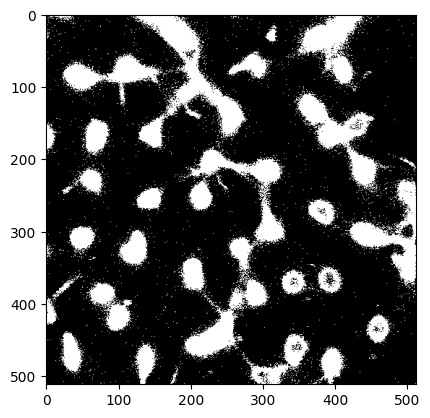

In [156]:
filled, marker = fillhole_morphology(bin_data)
plt.imshow(filled[1], 'gray')

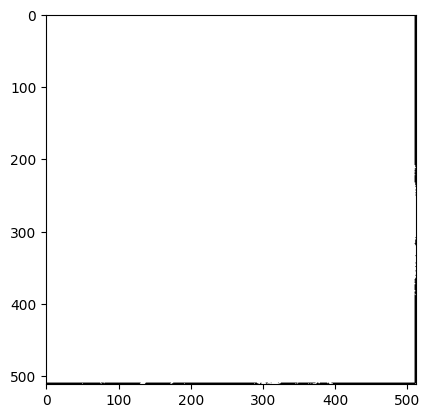

In [140]:
plt.imshow(marker[1], 'gray')